# 6002 Project

### Antoniadis Christoforos , Kontoudakis Nikolaos, Tsamoura Evgenia 

In [3]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from itertools import product
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from typing import List
from sklearn.metrics import mean_squared_error
%matplotlib inline
sns.set()

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.naive_bayes import BernoulliNB

warnings.filterwarnings('ignore')

In [4]:
# change the following on your pc!
projectPath = "/home/nikos/Documents/6002_project"
# projectPath = "C:/Users/Chris/Downloads"
dataPath = projectPath + "/smp500.csv"

In [5]:
smp500 = pd.read_csv(dataPath, sep= ',', header= 0, names=["date",	"open",	"high",	"low", "close",	"adj. close", "volume"])
smp500 = smp500.drop(columns = ["adj. close"])
smp500['date'] = pd.to_datetime(smp500['date'])
# set date as key
# smp500= smp500.set_index(smp500['date']).to_period('M').drop(columns='date')
smp500= smp500.set_index(smp500['date']).to_period('M')
smp500

,date,open,high,low,close,volume
date,,,,,,
2024-11,2024-11-29,6003.98,6044.17,6003.98,6032.38,2444420000
2024-11,2024-11-27,6014.11,6020.16,5984.87,5998.74,3363340000
2024-11,2024-11-26,6000.03,6025.42,5992.27,6021.63,3835170000
2024-11,2024-11-25,5992.28,6020.75,5963.91,5987.37,5633150000
2024-11,2024-11-22,5944.36,5972.90,5944.36,5969.34,4141420000
...,...,...,...,...,...,...
2022-01,2022-01-07,4697.66,4707.95,4662.74,4677.03,4181510000
2022-01,2022-01-06,4693.39,4725.01,4671.26,4696.05,4295280000
2022-01,2022-01-05,4787.99,4797.70,4699.44,4700.58,4887960000


### Data validation

In [7]:
print("There are %s na values" %(smp500.isna().sum().sum()))
print("There are %s zero values" % (smp500[smp500 == 0].sum(numeric_only=True).sum()))

# Check inconsistencies
# at every row low must be the lowest value
print("There are %s rows that the low of the row is higher than any other value" % (smp500[(smp500.low> smp500.high) & (smp500.low> smp500.close) & (smp500.low > smp500.open)].sum(numeric_only=True).sum()))

There are 0 na values
There are 0.0 zero values
There are 0.0 rows that the low of the row is higher than any other value


### Outlier Detection

In [9]:
#check the values of each row per specific column for outliers
def identifyOutliers(columnName):
    Zsmp500 = (smp500[columnName] - np.mean(smp500[columnName])) / np.std(smp500[columnName])
    return Zsmp500[(Zsmp500 > 3 ) | (Zsmp500 < -3 )].index
    
# run the function for every column
# smp500= smp500.drop(removeOutliers('open'), axis= 0).drop(removeOutliers('high'), axis= 0).drop(removeOutliers('low'), axis= 0).drop(removeOutliers('close'), axis= 0).drop(removeOutliers('volume'), axis= 0)
identifyOutliers('volume')

PeriodIndex(['2024-09', '2024-06', '2024-06', '2024-03', '2023-12', '2023-09',
             '2023-06', '2023-03', '2022-12', '2022-09', '2022-06', '2022-06',
             '2022-05', '2022-03', '2022-03', '2022-03', '2022-02', '2022-01'],
            dtype='period[M]', name='date')

### Ploting

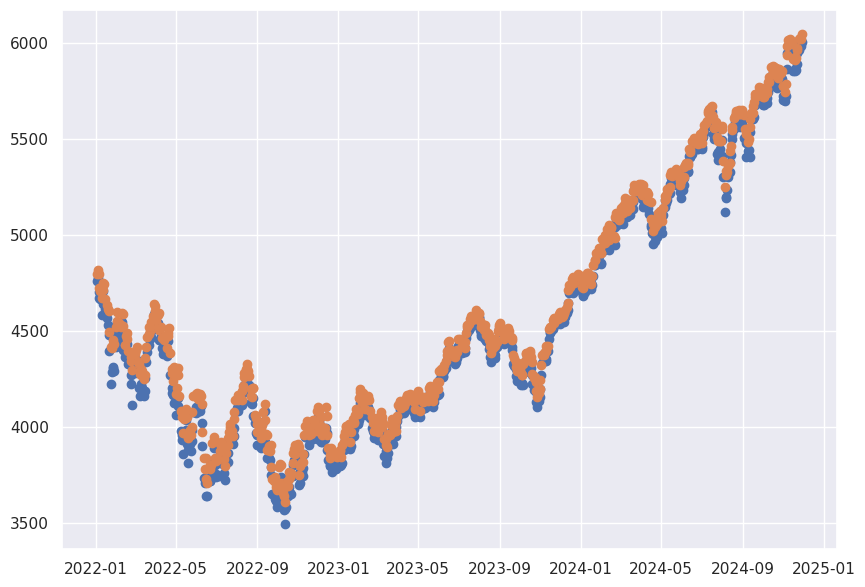

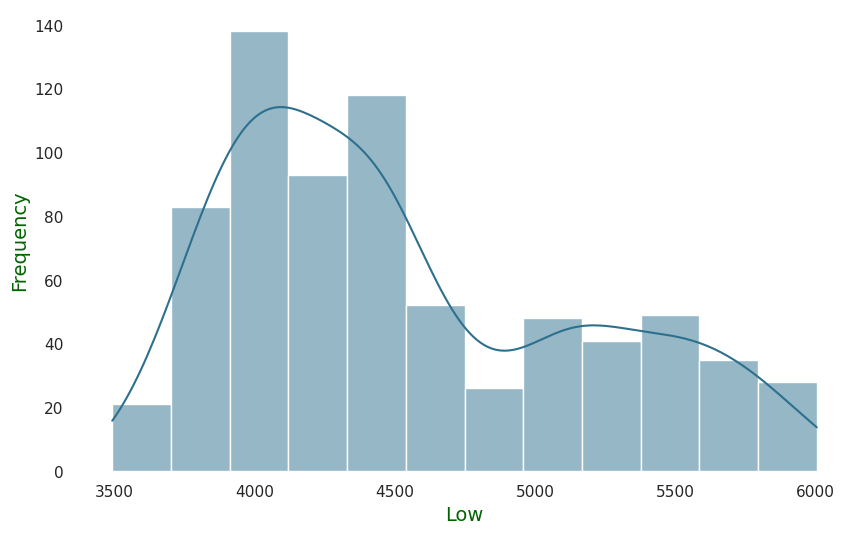

In [11]:
#scater plot
plt.figure(figsize=(10, 7))
plt.scatter(y= smp500.low, x =smp500.date)
plt.scatter(y= smp500.high, x =smp500.date)

# histogram
sns.set(style="white")
colors = sns.color_palette("viridis", n_colors=10)

# plotting the SAT score distribution using Seaborn with a KDE (Kernel Density Estimate) plot
plt.figure(figsize=(10, 6))
# sns.histplot(smp500.open, kde=True, color=colors[0])
# sns.histplot(smp500.close, kde=True, color=colors[1])
# sns.histplot(smp500.high, kde=True, color=colors[2])
sns.histplot(smp500.low, kde=True, color=colors[3])
# sns.histplot(smp500.volume, kde=True, color=colors[3])

# Remove left and bottom spines to eliminate the box
sns.despine(left=True, bottom=True)

# set the title and labels
# plt.title("SAT Score Distribution", fontsize=18, color='darkgreen')
plt.xlabel("Low", fontsize=14, color='darkgreen')
plt.ylabel("Frequency", fontsize=14, color='darkgreen')


# display the plot
plt.show()

# Q2

### Naive Aproach

In [14]:
# group by month
monthly_summary = smp500.drop(columns = ['volume']).groupby(smp500.index).mean()
# print(monthly_summary)
predictions = monthly_summary[monthly_summary.index == '2022-01'].reset_index(drop=True)
predictions = predictions.iloc[0]
data = smp500.drop(columns = 'volume')[smp500.index >= '2022-02']
first_year = monthly_summary[(monthly_summary.index >= '2022-01')&(monthly_summary.index < '2023-01')]
# repeat the row to match the size of the test data
repeated_naiveResult = pd.DataFrame([predictions] * len(first_year), columns=first_year.columns, index=first_year.index)

# MAE = np.abs(monthly_summary - repeated_naiveResult).mean().mean()
# MSE2 = mean_squared_error(monthly_summary.high, repeated_naiveResult.high)
# manual calculation for every column

MSE = ((first_year.drop(columns= 'date') - repeated_naiveResult.drop(columns= 'date'))**2).sum(axis=0)/len(first_year)
MAD = np.abs((first_year - repeated_naiveResult)).sum(axis=0)/len(first_year)
print(MSE)
print(MAD)
#data.to_csv("rawdata.csv", sep=',', encoding='utf-8', index=True, header=True)
#repeated_naiveResult.to_csv("repeatednaiveresult.csv", sep=',', encoding='utf-8', index=True, header=True

open     306778.980965
high     306393.898053
low      287555.543074
close    295547.729823
dtype: float64
date     165 days 22:21:07.983000960
open                      482.431562
high                      482.569517
low                       465.105063
close                     473.115716
dtype: object


In [15]:
# def rollingWindow():

#     month = 1
#     averageValues = []
#     while month <= 12:
#         # Create the start and end dates as datetime objects
#         start = pd.Timestamp(year=2022, month=month, day=1)
#         end_month = (month + 2) if (month + 2) <= 12 else (month + 2) - 12
#         end_year = 2022 if (month + 2) <= 12 else 2023
#         end = pd.Timestamp(year=end_year, month=end_month, day=27)
        
#         # Filter data and calculate rolling mean
#         data_in_range = smp500.loc[start:end]
#         print(smp500.loc[start:end])
#         rolling_mean = data_in_range['close'].rolling(len(data_in_range)).mean()
#         averageValues.append(rolling_mean)
        
#         month += 1
#     return averageValues

In [16]:
# Calculate 30-day Simple Moving Average (SMA)
# smp500['close'] = smp500['close'].rolling(len(smp500['2022-01-03':'2022-03-31'])).mean()
# smp500['close'] = smp500['close'].rolling(len(smp500['2022-01-03':'2022-03-31'])).mean()
# smp500['close'] = smp500['close'].rolling(len(smp500['2022-01-03':'2022-03-31'])).mean()

# df.index = pd.to_datetime(df.index)

# df.index = pd.to_datetime(df.index)

# Group by year and month and calculate row number for each month
#first_year['month_row_number'] = first_year.groupby([first_year.index.year, first_year.index.month]).cumcount() + 1
#first_year_sorted = first_year.sort_values(by = first_year.index, ascending = True)
first_year.sort_index(ascending = True, inplace=True)

# Display the updated DataFrame
#print(first_year[['month_row_number']])
print(first_year)

                                 date         open         high          low  \
date                                                                           
2022-01 2022-01-16 04:48:00.000000000  4585.263000  4619.576000  4528.042000   
2022-02 2022-02-13 12:37:53.684210432  4436.878947  4473.607368  4392.072632   
2022-03 2022-03-16 00:00:00.000000000  4388.294348  4424.881739  4351.570000   
2022-04 2022-04-15 19:12:00.000000000  4409.360500  4439.264500  4361.126500   
2022-05 2022-05-15 06:51:25.714285824  4037.780000  4082.188095  3986.214286   
2022-06 2022-06-15 11:25:42.857142784  3908.924286  3942.405238  3864.070000   
2022-07 2022-07-16 08:24:00.000000000  3893.241000  3931.058000  3866.241000   
2022-08 2022-08-15 15:39:07.826086912  4164.375652  4189.813043  4136.988261   
2022-09 2022-09-16 13:42:51.428571392  3860.814286  3890.228571  3817.548571   
2022-10 2022-10-16 05:42:51.428571392  3712.360476  3761.631429  3683.410000   
2022-11 2022-11-14 21:42:51.428571392  3

In [17]:
#We compute a fast moving average of 40 days (MA40) and a slow moving average of 252 days (MA252) on the Adj. Close Price.
data = first_year.copy()

MAF = 3
MAS = 6

data['MASlow'] = data['low'].rolling(MAS).mean()
data['MAFast'] = data['low'].rolling(MAF).mean()
data.dropna(inplace=True)
data.head()

,date,open,high,low,close,MASlow,MAFast
date,,,,,,,
2022-06,2022-06-15 11:25:42.857142784,3908.924286,3942.405238,3864.070000,3898.946667,4247.182570,4070.470262
2022-07,2022-07-16 08:24:00.000000000,3893.241000,3931.058000,3866.241000,3911.729500,4136.882403,3905.508429
2022-08,2022-08-15 15:39:07.826086912,4164.375652,4189.813043,4136.988261,4158.563043,4094.368341,3955.766420
2022-09,2022-09-16 13:42:51.428571392,3860.814286,3890.228571,3817.548571,3850.520476,4005.364770,3940.259277
2022-10,2022-10-16 05:42:51.428571392,3712.360476,3761.631429,3683.410000,3726.050952,3892.412020,3879.315611


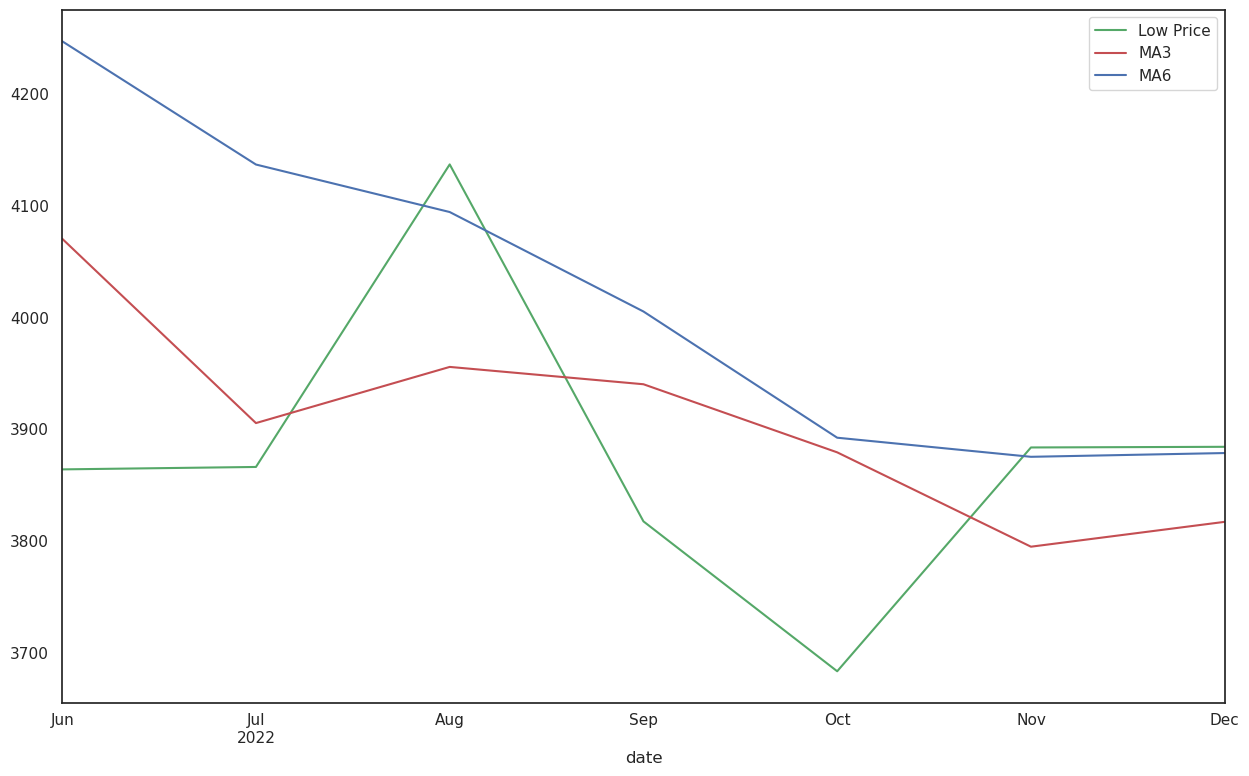

In [18]:
plt.figure(figsize= (15,9))
data['low'].plot(color = 'g', label = 'Low Price')
data['MAFast'].plot(color = 'r', label = 'MA{}'.format(MAF) )
data['MASlow'].plot(color = 'b', label = 'MA{}'.format(MAS) )
plt.legend()
plt.show()

### Exponential Smoothing

### 1.0 Simple Exponential Smoothing

In [21]:
# Apply Simple Exponential Smoothing
alpha = 0.15
ses_model = SimpleExpSmoothing(data['low']).fit(smoothing_level=alpha, optimized=False)
# Forecast for the next 10 periods
forecast = ses_model.forecast(11)
print(forecast)

2023-01    3867.251318
2023-02    3867.251318
2023-03    3867.251318
2023-04    3867.251318
2023-05    3867.251318
2023-06    3867.251318
2023-07    3867.251318
2023-08    3867.251318
2023-09    3867.251318
2023-10    3867.251318
2023-11    3867.251318
Freq: M, dtype: float64


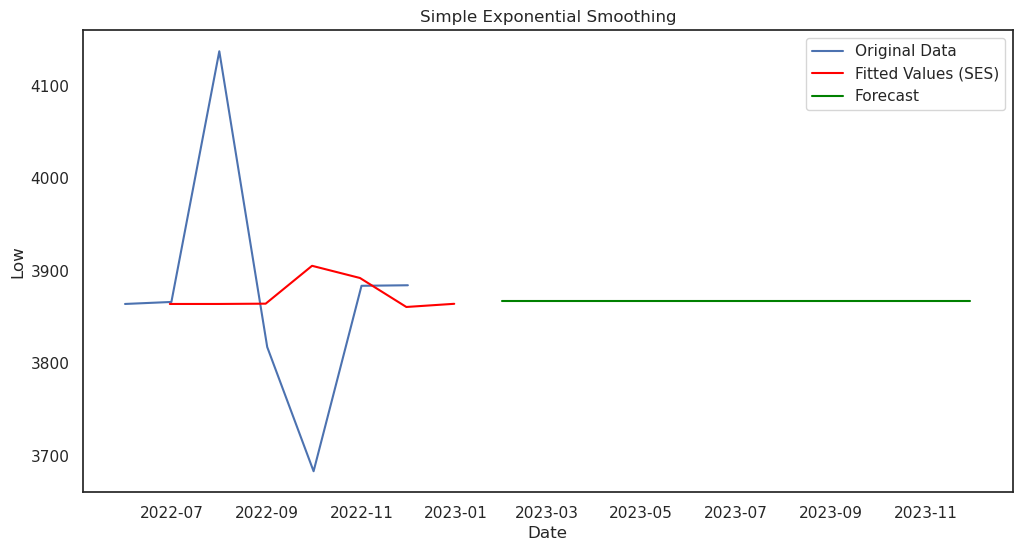

In [22]:
# Plot the original data and the forecast

plt.figure(figsize=(12, 6))
plt.plot(data.index.to_timestamp(), data['low'], label='Original Data')
plt.plot(ses_model.fittedvalues, label='Fitted Values (SES)', color='red')
plt.plot(forecast, label='Forecast', color='green')
plt.title('Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.show()

### Double Exponential Smoothing

In [24]:
# Perform double exponential smoothing
#Source: https://vbatopandas.blogspot.com/2023/12/how-to-use-statsmodels-library-in.html
model = sm.tsa.ExponentialSmoothing(data['low'], trend='add')
des_model = model.fit(smoothing_level=0.3, smoothing_slope=0.2)
data['Forecast'] = des_model.fittedvalues

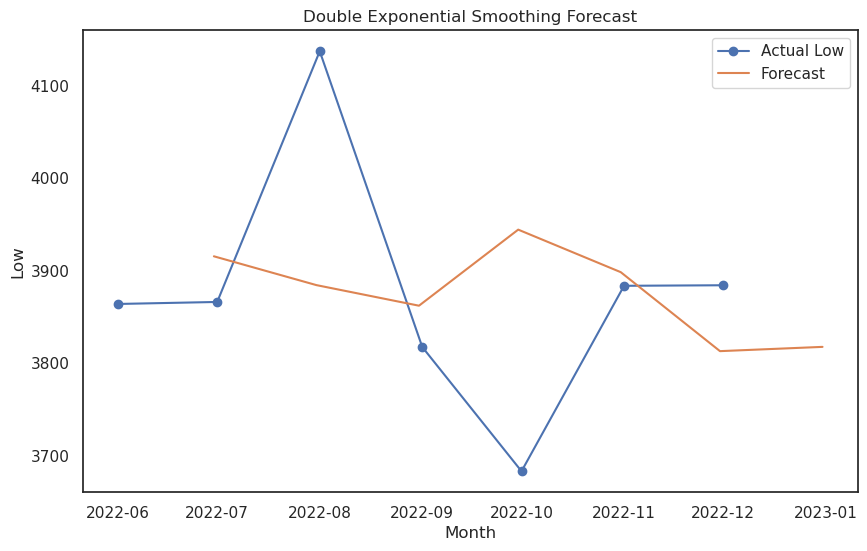

In [25]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(data.index.to_timestamp(), data['low'], label='Actual Low', marker='o')
plt.plot(data['Forecast'], label='Forecast')
plt.xlabel('Month')
plt.ylabel('Low')
plt.title('Double Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Holt's Linear Trend Model

In [27]:
# Apply Holt's Linear Trend Model
# Source: https://www.statology.org/how-to-apply-exponential-smoothing-to-time-series-data-in-python/
holt_model = ExponentialSmoothing(data['low'], trend='add').fit()

# Forecast for the next 10 periods
forecast_holt = holt_model.forecast(10)

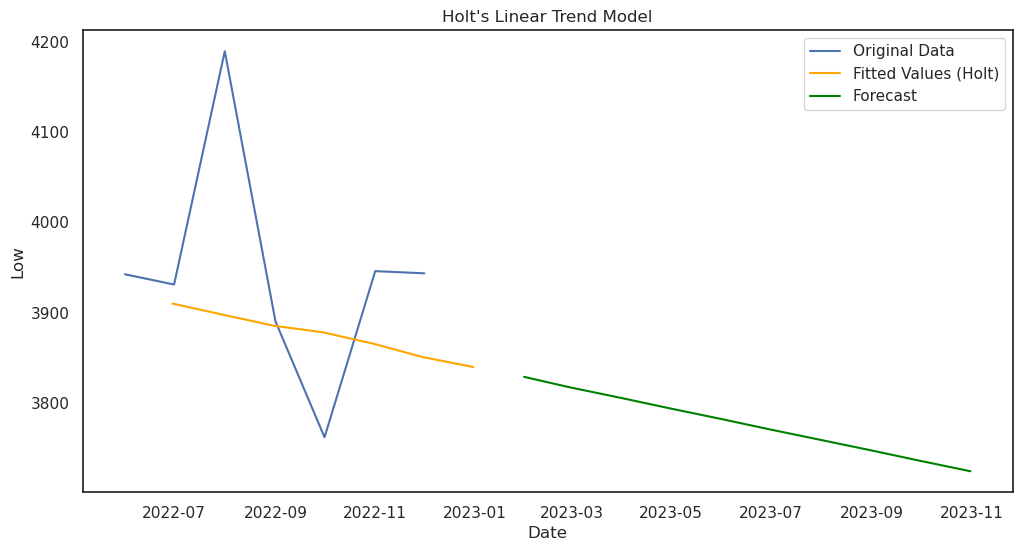

In [28]:
# Plot the original data and the forecast
plt.figure(figsize=(12, 6))
plt.plot(data.index.to_timestamp(), data['high'], label='Original Data')
plt.plot(holt_model.fittedvalues, label='Fitted Values (Holt)', color='orange')
plt.plot(forecast_holt, label='Forecast', color='green')
plt.title("Holt's Linear Trend Model")
plt.xlabel('Date')
plt.ylabel('Low')
plt.legend()
plt.show()

### Holt Winter’s Exponential Smoothing (HWES)

In [30]:
data = data.copy()
#data['date'] = pd.to_datetime(data['date'])

In [31]:
# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]


def plot_func(forecast1: List[float],
              forecast2: List[float],
              forecast3: List[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['date'], y=train['low'], name='Train'))
    fig.add_trace(go.Scatter(x=test['date'], y=test['low'], name='Train'))
    fig.add_trace(go.Scatter(x=test['date'], y=forecast1, name='Simple'))
    fig.add_trace(go.Scatter(x=test['date'], y=forecast2, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test['date'], y=forecast3, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Low Volume')
    return fig.show()

In [32]:
# Fit simple model and get forecasts
print(train['low'])
train = train.sort_index()
model_simple = SimpleExpSmoothing(train['low']).fit(optimized=True)
forecasts_simple = model_simple.forecast(len(test))

date
2022-06    3864.070000
2022-07    3866.241000
2022-08    4136.988261
2022-09    3817.548571
2022-10    3683.410000
2022-11    3883.688095
Freq: M, Name: low, dtype: float64


In [33]:
# Fit Holt's model and get forecasts
model_holt = Holt(train['low'], damped=True).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(test))

In [34]:
# Fit Holt Winters model and get forecasts
model_holt_winters = ExponentialSmoothing(train['low'], trend='mul',
                                          seasonal='mul', seasonal_periods=12)\
                                          .fit(optimized=True)
forecasts_holt_winters = model_holt_winters.forecast(len(test))

ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [ ]:
print(model_holt_winters.summary())

In [ ]:
# Plot the forecasts
plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters,  "Holt-Winters Exponential Smoothing")